# Moment Tensor Wavefield Inversion - Multi Component


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import os
# import scipy as sp
# from obspy.imaging.beachball import beachball
# from obspy.imaging.beachball import beach

# from scipy.sparse.linalg import LinearOperator, cg, lsqr
# from scipy.linalg import lstsq

# from pylops.basicoperators import HStack, VStack
from pylops.utils import dottest
from pylops.utils.wavelets import *
# from pylops.optimization.sparsity import *


In [2]:
from pyfrac.modelling.kirchhoff import Kirchhoff
# from pyfrac.modelling.trueamp_kirchhoff import Kirchhoff as TAKirchhoff

from pyfrac.locationsolvers.localisationutils import get_max_locs
from pyfrac.mtsolvers.mtwi import *
from pyfrac.mtsolvers.homo_mti import collect_source_angles, multicomp_Greens_Pwave
from pyfrac.mtsolvers.mtutils import get_mt_computation_dict, get_mt_at_loc, expected_sloc_from_mtwi

from pyfrac.visualisation.eventimages import locimage3d

# Load eFD Data

In [3]:
data_dir = '../../data/pyfrac_SOFIModelling'

In [4]:
def read_seis(seisfile, nr):
    # s_wave_file = os.path.join(data_path,'test.bin.curl')
    seis_flat = np.loadtxt(seisfile)

    # determine number of timesamples and ensure it saved fully
    nt = int(seis_flat.shape[0] / nr)
    try:
        seis_flat.reshape((nr, nt))
    except:
        print('Not good dims \n nt:%i nr:%i \n vz flat:%i' % (nt, nr, seis_flat.shape[0]))

    # Resample to 2D
    seis = seis_flat[:nt * nr].reshape((nr, nt))
    return seis

In [5]:
# RECEIVERS
recs_xzy = np.loadtxt(os.path.join(data_dir,'inputs/griddedarray_xzy_20m.dat')).T
nr = recs_xzy.shape[1]
print(nr)


143


In [6]:
expname = 'MT-90-90-180_Homogeneous_griddedarray'

# Vz is Vy cause SOFI is not cool (or consistent!)
vx = read_seis(os.path.join(data_dir,'outputs/su/%s_vx.txt'%expname), 
               nr=nr)
vy = read_seis(os.path.join(data_dir,'outputs/su/%s_vz.txt'%expname), 
               nr=nr)
vz = read_seis(os.path.join(data_dir,'outputs/su/%s_vy.txt'%expname), 
               nr=nr)

sdt = 1e-3 #ms
t_shift = 167
tdur = 500
efd_scaler = np.max(abs(vz))

vx = vx[:,t_shift:t_shift+tdur]/efd_scaler
vy = vy[:,t_shift:t_shift+tdur]/efd_scaler
vz = vz[:,t_shift:t_shift+tdur]/efd_scaler

print(np.max(vz))

FD_data = np.array([vx,vy,vz])

0.25529863787450136


In [7]:
np.max(abs(vz))

0.2553047986833471

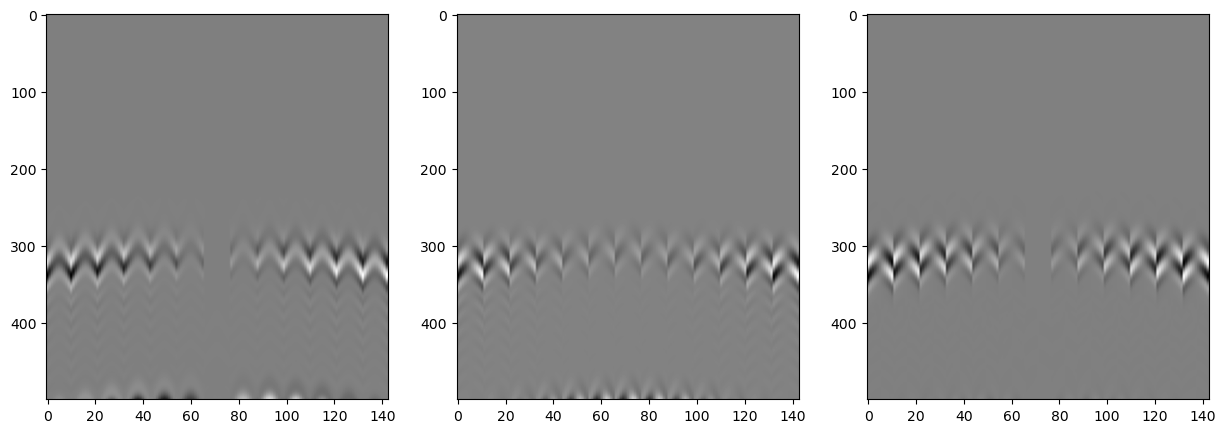

In [8]:
fig,axs = plt.subplots(1,3,figsize=[15,5])
axs[0].imshow(vx.T, aspect='auto',cmap='binary_r')
axs[1].imshow(vy.T, aspect='auto',cmap='binary_r')
axs[2].imshow(vz.T, aspect='auto',cmap='binary_r')

# 3D Model & Source Params

In [9]:
abs_bounds = 30
dx = dy = dz = 5
nx = 112
ny = 128
nz = 120
print(nx,ny,nz)

mod_w_bounds = np.fromfile(os.path.join(data_dir,'inputs/models/Homogeneous_xyz.vp'),dtype='float32').reshape([nx,ny,nz])

# Remove absorbing boundaries
mod = mod_w_bounds[abs_bounds:-abs_bounds,abs_bounds:-abs_bounds,:-abs_bounds] # z has free surface
nx, ny, nz = mod.shape
x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz
print(nx,ny,nz)
recs = np.array([recs_xzy[0]-(abs_bounds*dx),recs_xzy[2]-(abs_bounds*dx),recs_xzy[1]])

112 128 120
52 68 90


In [10]:
# Source Parameters
omega_p = 20 

sx = nx//2
sy = ny//2
sz = 2*nz//3
sloc_ind =[sx,sy,sz]

In [11]:
nx//2

26

## Get all necessary components

In [12]:
# TRAVEL TIME TABLE
trav = Kirchhoff._traveltime_table(z, 
                                   x, 
                                   y=y, 
                                   recs=recs,  
                                   vel=mod, 
                                   mode='eikonal')

TTT_full = trav.reshape(nx,ny,nz,nr).transpose([3,0,1,2])

In [13]:
# AMPLITUDE TERMS
gamma_sourceangles, dist_table = collect_source_angles(x,y,z, reclocs=recs, nc=3)

### AREA OF INTEREST

In [14]:
# Make cube area of interest as can't consider the full subsurface body
hwin_nx_aoi, hwin_ny_aoi, hwin_nz_aoi = 15, 13, 11  # half windows to place source in center of region of interest
xsi, xfi = sloc_ind[0]-hwin_nx_aoi, sloc_ind[0]+hwin_nx_aoi+1   # start/end index of x-region of interest
ysi, yfi = sloc_ind[1]-hwin_ny_aoi, sloc_ind[1]+hwin_ny_aoi+1   # start/end index of y-region of interest
zsi, zfi = sloc_ind[2]-hwin_nz_aoi, sloc_ind[2]+hwin_nz_aoi+1   # start/end index of z-region of interest

In [15]:
# Parameters only for the area of interest
gamma_sourceangles_aoi = gamma_sourceangles[:, :, xsi:xfi, ysi:yfi, zsi:zfi]
dist_table_aoi = dist_table[:, xsi:xfi, ysi:yfi, zsi:zfi]
tt_table_aoi = TTT_full[:, xsi:xfi, ysi:yfi, zsi:zfi]

nr, nx_aoi, ny_aoi, nz_aoi = tt_table_aoi.shape
print(nr, nx_aoi, ny_aoi, nz_aoi)

143 31 27 23


In [16]:
MT_comp_dict = get_mt_computation_dict()  # This keeps everything nice and clean in the later G compute

## Compute Greens for area of interest

In [17]:
Gx, Gy, Gz = multicomp_Greens_Pwave(nxyz=[nx_aoi, ny_aoi, nz_aoi],
                                    nr=nr,
                                    gamma_sourceangles=gamma_sourceangles_aoi,
                                    dist_table=dist_table_aoi,
                                    vel=mod,
                                    MT_comp_dict=MT_comp_dict,
                                    omega_p=1,
                                    )

In [18]:
Gx.shape

(6, 143, 31, 27, 23)

# Moment Tensor Kirchhoff Imaging

### MAKE OPERATOR

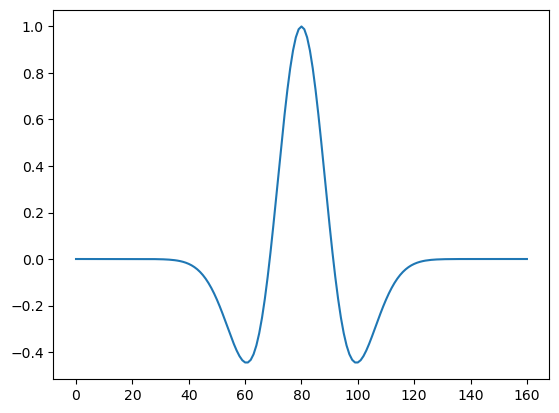

In [19]:
dt = sdt
nt = vz.shape[1]
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:81], f0=omega_p)
plt.plot(wav)

In [20]:
Mstack_Op = multicomp_pwave_mtioperator(x=x[xsi:xfi],
                                        y=y[ysi:yfi],
                                        z=z[zsi:zfi],
                                        recs=recs,
                                        t=t,
                                        wav=wav,
                                        wavc=wavc,
                                        tt_table=tt_table_aoi,
                                        Gx=Gx,
                                        Gy=Gy,
                                        Gz=Gz,
                                        Ms_scaling = 1e9,
                                        engine='numba'
                                        )

Dot test passed, v^H(Opu)=-169.862524113264 - u^H(Op^Hv)=-169.86252411326385


### Make data with forward operation, checking timeshift from FD modelling and that nothing looks crazy

In [21]:
# Modelled MT
MT_aoi = np.zeros([6, nx_aoi, ny_aoi, nz_aoi])  # MT components as images
MT_selected = -1 * np.array([0,0,0,1,0,0]) #  np.array([1,1,1,0,0,0]) 
MT_aoi[:, nx_aoi//2, ny_aoi//2, nz_aoi//2] = MT_selected

# Generated Data
data = Mstack_Op @ MT_aoi.ravel()
data = data.reshape(3, nr, nt)

In [22]:
# data_scaler = np.max(abs(data))
# data /= data_scaler
# print(data_scaler)

In [23]:
print(np.mean(abs(data)))
print(np.mean(abs(FD_data)))

3.124653244788447e-05
0.003553430223370288


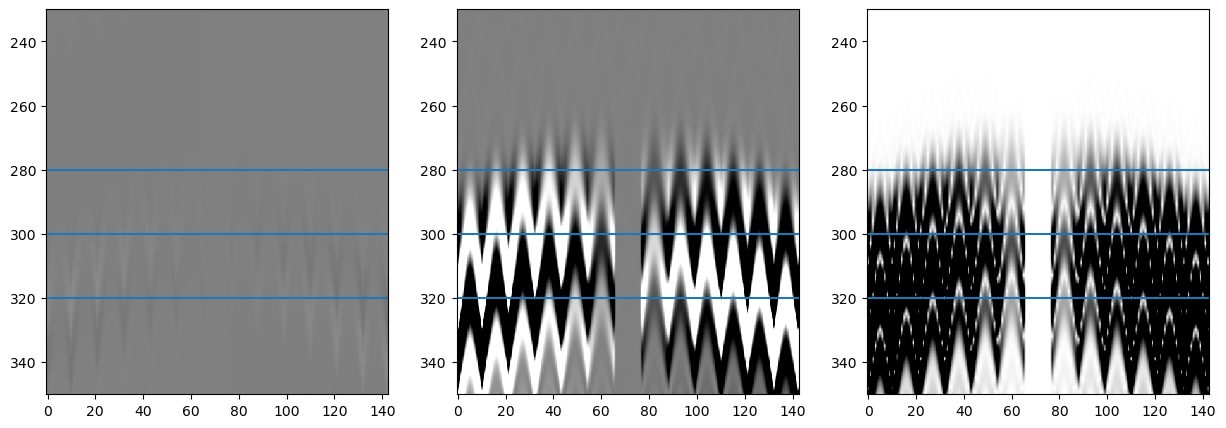

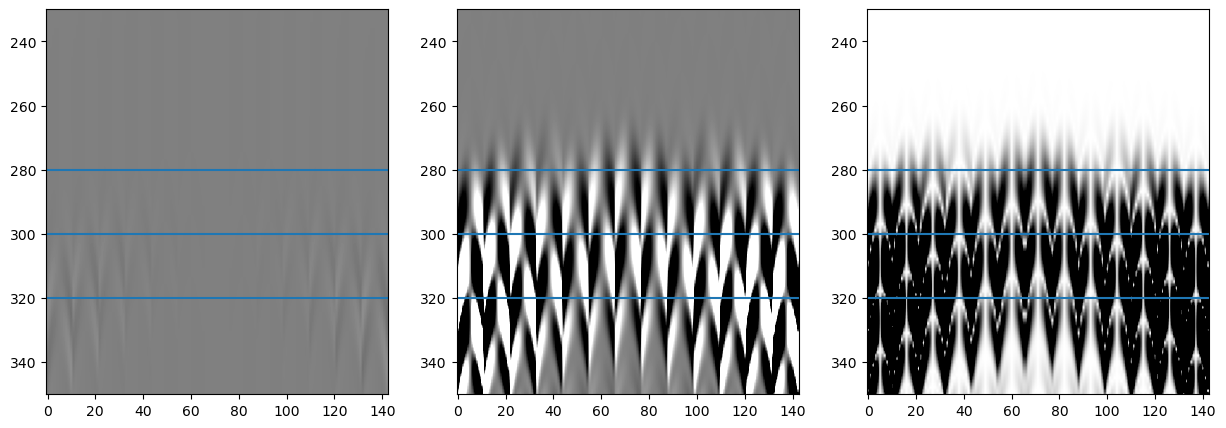

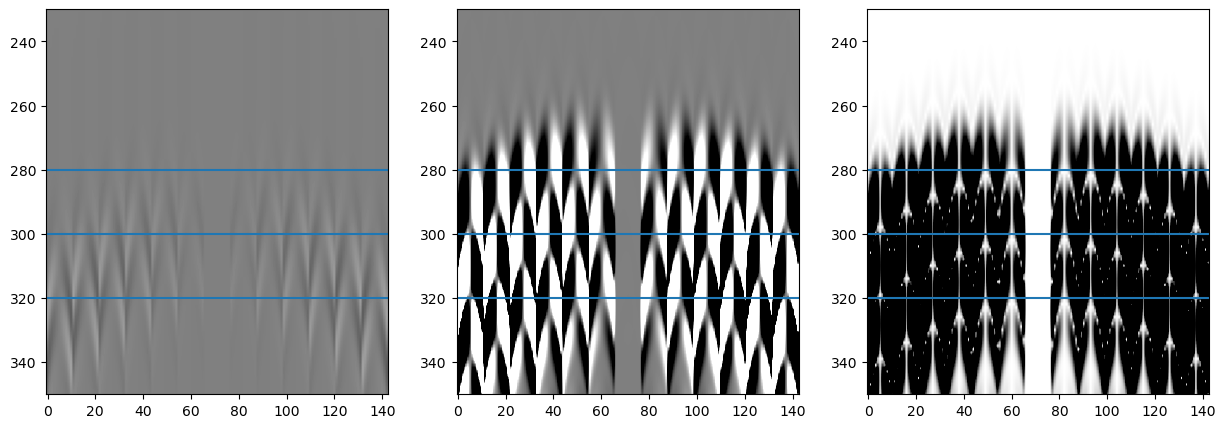

In [24]:
fig,axs = plt.subplots(1,3,figsize=[15,5])
axs[0].imshow(data[0].reshape(-1, nt).T, aspect='auto',cmap='binary_r', vmin=-1e-2, vmax=1e-2)
axs[1].imshow(vx.T, aspect='auto',cmap='binary_r', vmin=-1e-2, vmax=1e-2)
axs[2].imshow(abs(vx.T)-abs(data[0].reshape(-1, nt).T), aspect='auto',cmap='binary', vmin=0, vmax=1e-2)
for ax in axs: ax.axhline([280]), ax.axhline([300]), ax.axhline([320]), ax.set_ylim([350,230])
    
fig,axs = plt.subplots(1,3,figsize=[15,5])
axs[0].imshow(data[1].reshape(-1, nt).T, aspect='auto',cmap='binary_r', vmin=-1e-2, vmax=1e-2)
axs[1].imshow(vy.T, aspect='auto',cmap='binary_r', vmin=-1e-2, vmax=1e-2)
axs[2].imshow(abs(vy.T)-abs(data[1].reshape(-1, nt).T), aspect='auto',cmap='binary', vmin=0, vmax=1e-2)
for ax in axs: ax.axhline([280]), ax.axhline([300]), ax.axhline([320]), ax.set_ylim([350,230])

fig,axs = plt.subplots(1,3,figsize=[15,5])
axs[0].imshow(data[2].reshape(-1, nt).T, aspect='auto',cmap='binary_r', vmin=-1e-2, vmax=1e-2)
axs[1].imshow(vz.T, aspect='auto',cmap='binary_r', vmin=-1e-2, vmax=1e-2)
axs[2].imshow(abs(vz.T)-abs(data[2].reshape(-1, nt).T), aspect='auto',cmap='binary', vmin=0, vmax=1e-2)
for ax in axs: ax.axhline([280]), ax.axhline([300]), ax.axhline([320]), ax.set_ylim([350,230])


In [ ]:
nxyz=[nx_aoi, ny_aoi, nz_aoi]

# ADJOINT
mt_adj = adjoint_mtmodelling(FD_data, Mstack_Op, nxyz)

# LSQR
mt_inv = lsqr_mtsolver(FD_data, Mstack_Op, nxyz)

# FISTA
mt_fista = fista_mtsolver(FD_data, Mstack_Op, nxyz, fista_niter=100, fista_damping=1e-13, verbose=True)


## Interpret results

In [ ]:
exp_sloc, _ = expected_sloc_from_mtwi(mt_inv)
print('Expected Source Location: \n', exp_sloc)
mt_at_loc = get_mt_at_loc(mt_inv, [int(exp_sloc[0]), int(exp_sloc[1]), int(exp_sloc[2])])
print('MT at expected Source Location (full): \n', mt_at_loc)
print('MT at expected Source Location (rounded): \n', np.round(mt_at_loc, decimals=2))

true_loc = [nx_aoi//2, ny_aoi//2, nz_aoi//2]
mt_at_loc = get_mt_at_loc(mt_inv, [nx_aoi//2, ny_aoi//2, nz_aoi//2])
print('\n')
print('True Source Location: \n', true_loc)
print('MT at true Source Location (full): \n', mt_at_loc)
print('MT at true Source Location (rounded): \n', np.round(mt_at_loc, decimals=2))

In [ ]:
exp_sloc, _ = expected_sloc_from_mtwi(mt_fista)
print('Expected Source Location: \n', exp_sloc)
mt_at_loc = get_mt_at_loc(mt_fista, [int(exp_sloc[0]), int(exp_sloc[1]), int(exp_sloc[2])])
print('MT at expected Source Location (full): \n', mt_at_loc)
print('MT at expected Source Location (rounded): \n', np.round(mt_at_loc, decimals=2))

true_loc = [nx_aoi//2, ny_aoi//2, nz_aoi//2]
mt_at_loc = get_mt_at_loc(mt_fista, true_loc)
print('\n')
print('True Source Location: \n', true_loc)
print('MT at true Source Location (full): \n', mt_at_loc)
print('MT at true Source Location (rounded): \n', np.round(mt_at_loc, decimals=2))

In [ ]:
clim = 1
locimage3d(mt_fista[0], sloc_ind[0]-xsi, sloc_ind[1]-ysi, sloc_ind[2]-zsi, clipval=[-clim, clim])
locimage3d(mt_fista[1], sloc_ind[0]-xsi, sloc_ind[1]-ysi, sloc_ind[2]-zsi, clipval=[-clim, clim])
locimage3d(mt_fista[2], sloc_ind[0]-xsi, sloc_ind[1]-ysi, sloc_ind[2]-zsi, clipval=[-clim, clim])
locimage3d(mt_fista[3], sloc_ind[0]-xsi, sloc_ind[1]-ysi, sloc_ind[2]-zsi, clipval=[-clim, clim])
locimage3d(mt_fista[4], sloc_ind[0]-xsi, sloc_ind[1]-ysi, sloc_ind[2]-zsi, clipval=[-clim, clim])
locimage3d(mt_fista[5], sloc_ind[0]-xsi, sloc_ind[1]-ysi, sloc_ind[2]-zsi, clipval=[-clim, clim]);

In [ ]:
locimage3d(mt_inv[0], int(exp_sloc[0])-xsi, int(exp_sloc[1])-ysi, int(exp_sloc[2])-zsi, clipval=[-clim, clim])
locimage3d(mt_inv[1], int(exp_sloc[0])-xsi, int(exp_sloc[1])-ysi, int(exp_sloc[2])-zsi, clipval=[-clim, clim])
locimage3d(mt_inv[2], int(exp_sloc[0])-xsi, int(exp_sloc[1])-ysi, int(exp_sloc[2])-zsi, clipval=[-clim, clim])
locimage3d(mt_inv[3], int(exp_sloc[0])-xsi, int(exp_sloc[1])-ysi, int(exp_sloc[2])-zsi, clipval=[-clim, clim])
locimage3d(mt_inv[4], int(exp_sloc[0])-xsi, int(exp_sloc[1])-ysi, int(exp_sloc[2])-zsi, clipval=[-clim, clim])
locimage3d(mt_inv[5], int(exp_sloc[0])-xsi, int(exp_sloc[1])-ysi, int(exp_sloc[2])-zsi, clipval=[-clim, clim]);